In [267]:
 
import urllib.request
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import re
import shifterator as sh
import matplotlib.pyplot as plt
import seaborn as sns
import random

labMTdata = pd.read_csv('labMT.csv')
tokenizer = RegexpTokenizer(r'\w+')

def get_labMT_score_lookup(window_size=0):
    filteredLabMTdata = labMTdata[ (labMTdata['Happiness Score'] <= 5 - window_size) | (labMTdata['Happiness Score'] >= 5 + window_size) ]
    return dict(zip(filteredLabMTdata['Word'], filteredLabMTdata['Happiness Score']))

stories = {
    "pride_and_predjudice": {
        "url": "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
        },
    "frankenstein": {
        "url": "https://www.gutenberg.org/cache/epub/84/pg84.txt",
    },
    "moby_dick": {
        "url": "https://www.gutenberg.org/cache/epub/2701/pg2701.txt",
    },
    "le_miserables": {
        "url": "https://www.gutenberg.org/cache/epub/135/pg135.txt",
    }
}

def extract_content_between(content, opening_string, closing_string):
    """
    Extracts content between opening_string and closing_string.
    
    Parameters:
    - content (str): The full text content
    - opening_string (str): The string marking the start
    - closing_string (str): The string marking the end
    
    Returns:
    - str: Content from opening_string to closing_string (inclusive), or None if not found
    """
    start_idx = content.find(opening_string)
    end_idx = content.find(closing_string)
    
    if start_idx == -1 or end_idx == -1:
        return None  # Strings not found
    
    return content[start_idx:end_idx + len(closing_string)]

def get_story(story_key):
    return stories[story_key]

def get_percentage_of_book(words, percentage):
    """
    Returns the first 'percentage' percent of the book as a list of words.

    Parameters:
    - words (list): List of words in the book.
    - percentage (float): Percentage of the book to return.
    """
    total_words = len(words)
    cutoff_index = int(total_words * (percentage / 100))
    return words[:cutoff_index]

def get_average_happiness(word_freq_df, labMTdata):
    total_weighted_score = 0
    total_count = 0
    
    for idx, row in word_freq_df.iterrows():
        word = row['word']
        count = row['counts']
        
        if word in labMTdata['Word'].values:
            score = labMTdata.loc[labMTdata['Word'] == word, 'Happiness Score'].values[0]
            total_weighted_score += score * count  # Weight by frequency!
            total_count += count
    
    return total_weighted_score / total_count if total_count > 0 else 0


In [268]:
moby_dick = get_story("moby_dick")
url = moby_dick["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
moby_dick_cleaned = extract_content_between(content, 'Call me Ishmael.', 'children, only found another orphan.')
split_moby_dick = tokenizer.tokenize(moby_dick_cleaned)  # Tokenize the entire content
md_words = [w.lower() for w in split_moby_dick]
shuffled_md_words = md_words.copy()
random.shuffle(shuffled_md_words)

pride_and_prejudice = get_story("pride_and_predjudice")
url = pride_and_prejudice["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

pride_and_prejudice_cleaned = extract_content_between(content, 'It is a truth universally acknowledged', 'had been the means of uniting them.')
split_pap = tokenizer.tokenize(pride_and_prejudice_cleaned)  # Tokenize the entire content
pap_words = [w.lower() for w in split_pap]
shuffled_pap_words = pap_words.copy()
random.shuffle(shuffled_pap_words)

frankenstein = get_story("frankenstein")
url = frankenstein["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
frankenstein_cleaned = extract_content_between(content, '_To Mrs. Saville, England._', 'lost in darkness and distance.')
split_frankenstein = tokenizer.tokenize(frankenstein_cleaned)  # Tokenize the entire content
frankenstein_words = [w.lower() for w in split_frankenstein]
shuffled_frankenstein_words = frankenstein_words.copy()
random.shuffle(shuffled_frankenstein_words)

le_miserables = get_story("le_miserables")
url = le_miserables["url"]
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')

# remove gutenberg header and footer
le_miserables_cleaned = extract_content_between(content, 'In 1815, M.', 'of itself, as the night comes when day is gone.]')
split_le_miserables = tokenizer.tokenize(le_miserables_cleaned)  # Tokenize the entire content
lm_words = [w.lower() for w in split_le_miserables]
shuffled_lm_words = lm_words.copy()
random.shuffle(shuffled_lm_words)


In [269]:
story_words = {
    "moby_dick": md_words,
    "frankenstein": frankenstein_words,
    "pride_and_predjudice": pap_words,
    "le_miserables": lm_words,
}

In [270]:
def get_scores(words, score_lookup):
    running_score = 0
    running_count = 0

    for word in words[:T]:
        if word in score_lookup:
            running_score += score_lookup[word]
            running_count += 1

    scores = [running_score / running_count if running_count > 0 else 0]
    return scores, running_score, running_count

def get_time_series_scores(words, running_score, running_count, score_lookup, T):
    scores = [running_score / running_count if running_count > 0 else 0]
    x_positions = [(T - 1) / 2]

    for i in range(1, len(words) - T + 1):
        outgoing = words[i - 1]
        incoming = words[i + T - 1]
        if outgoing in score_lookup:
            running_score -= score_lookup[outgoing]
            running_count -= 1
        if incoming in score_lookup:
            running_score += score_lookup[incoming]
            running_count += 1
        scores.append(running_score / running_count if running_count > 0 else 0)
        x_positions.append(i + (T - 1) / 2)
    
    return scores, x_positions


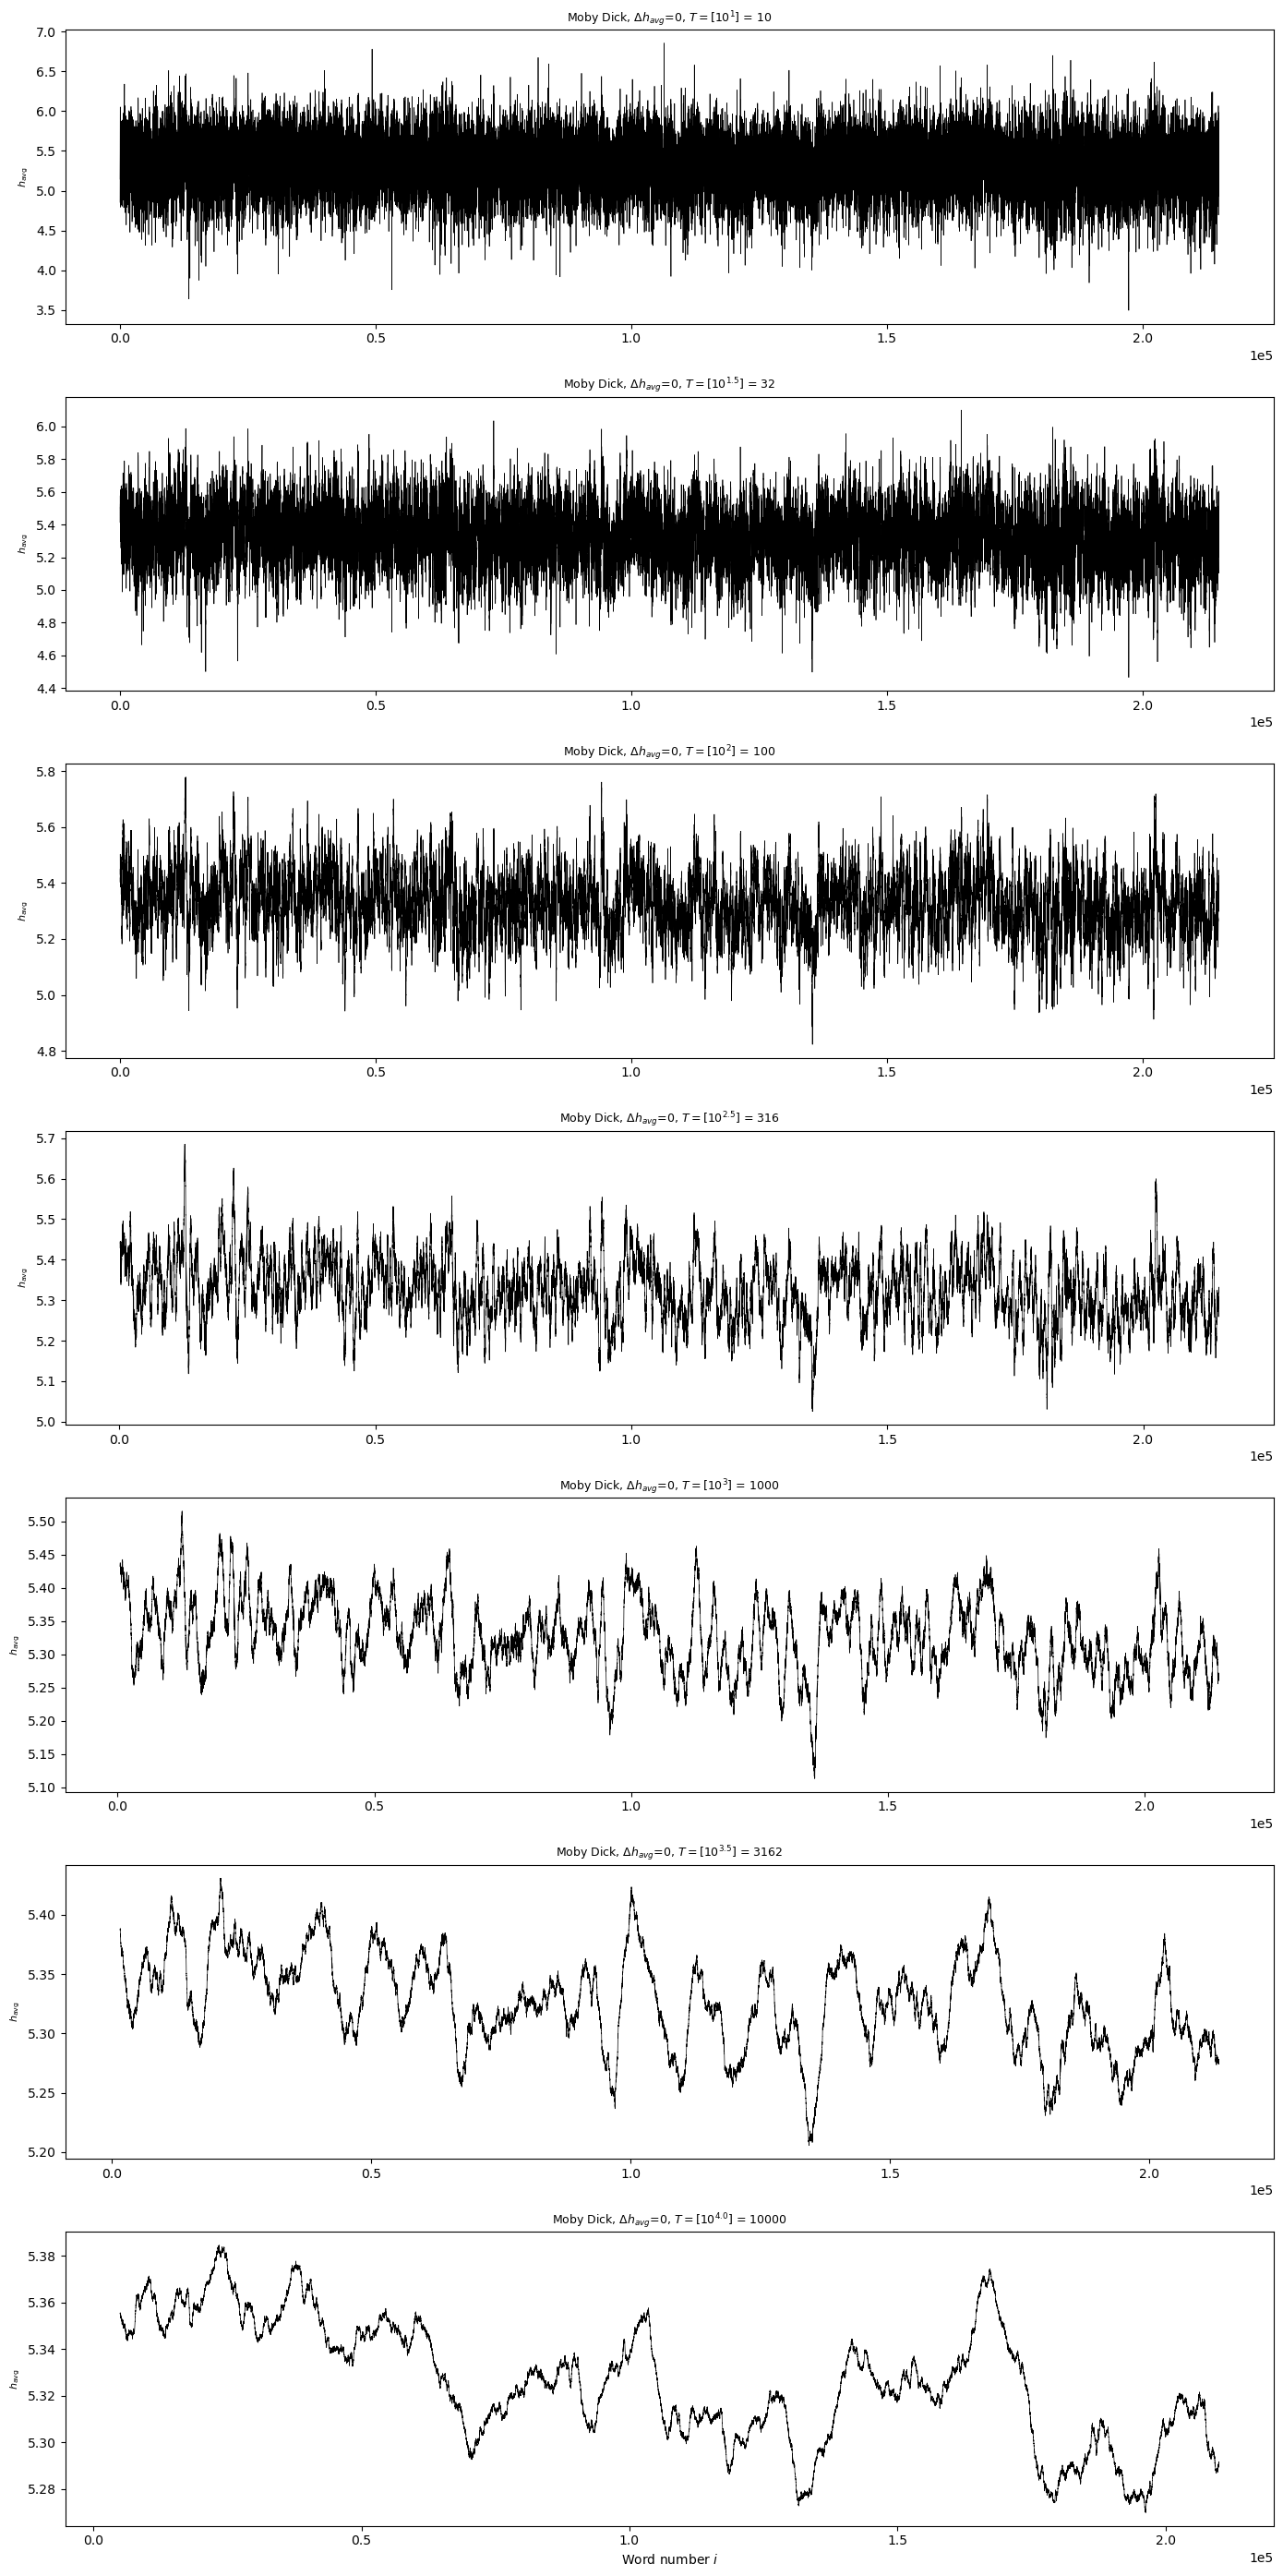

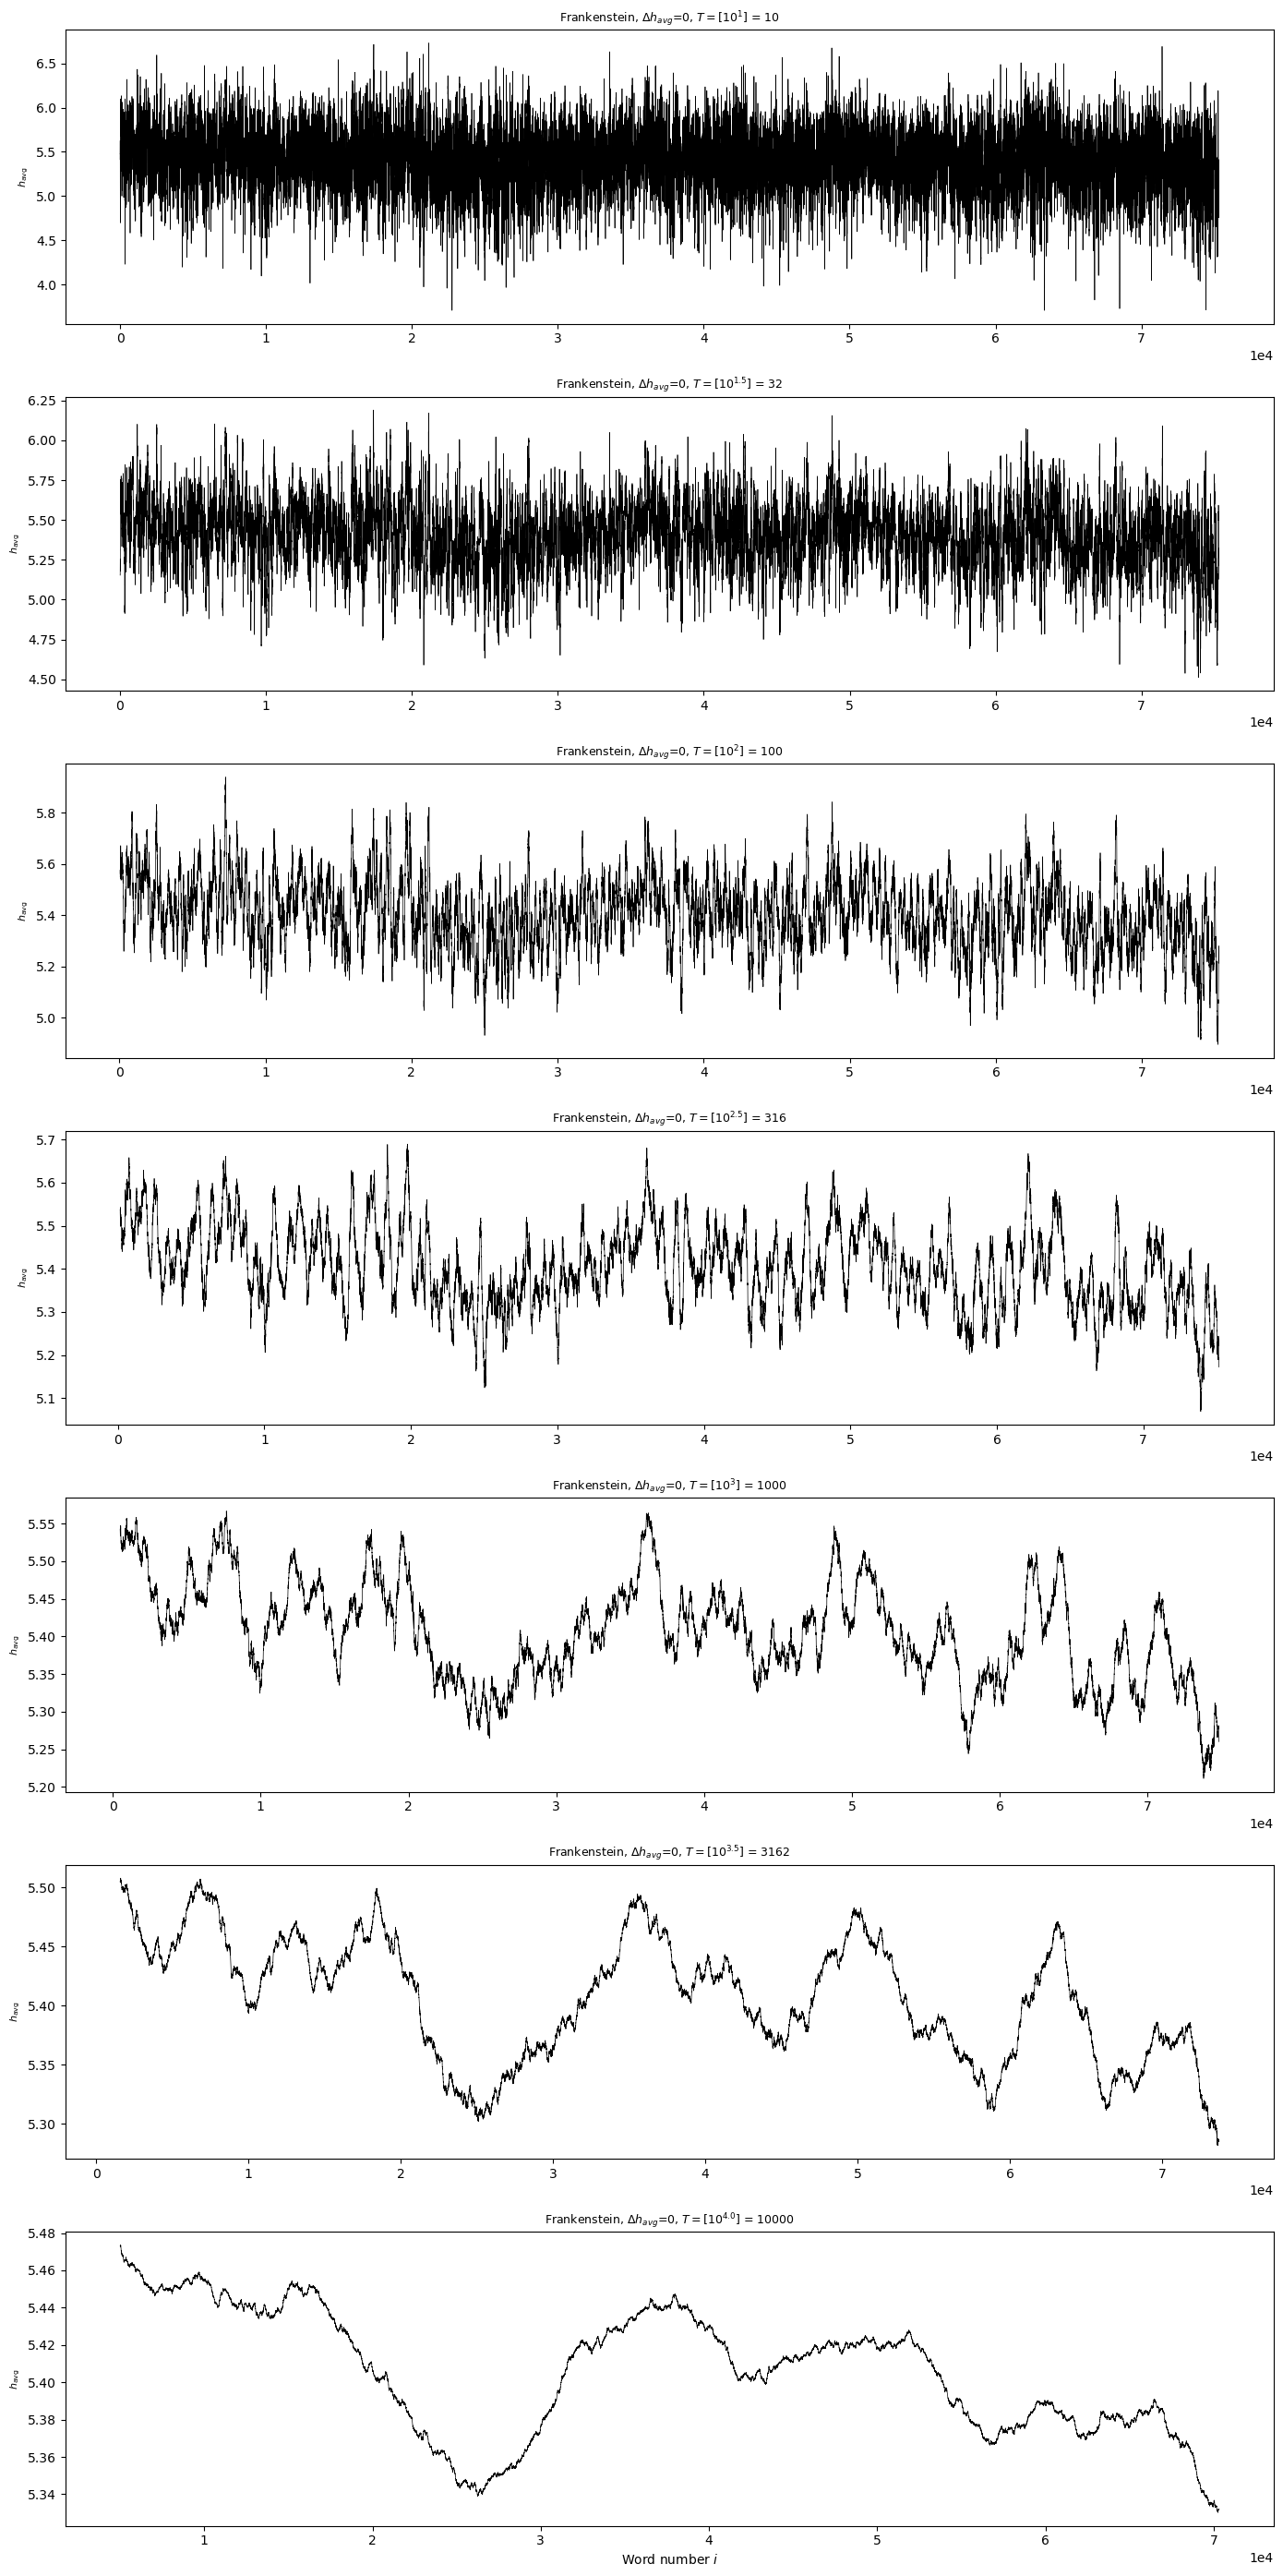

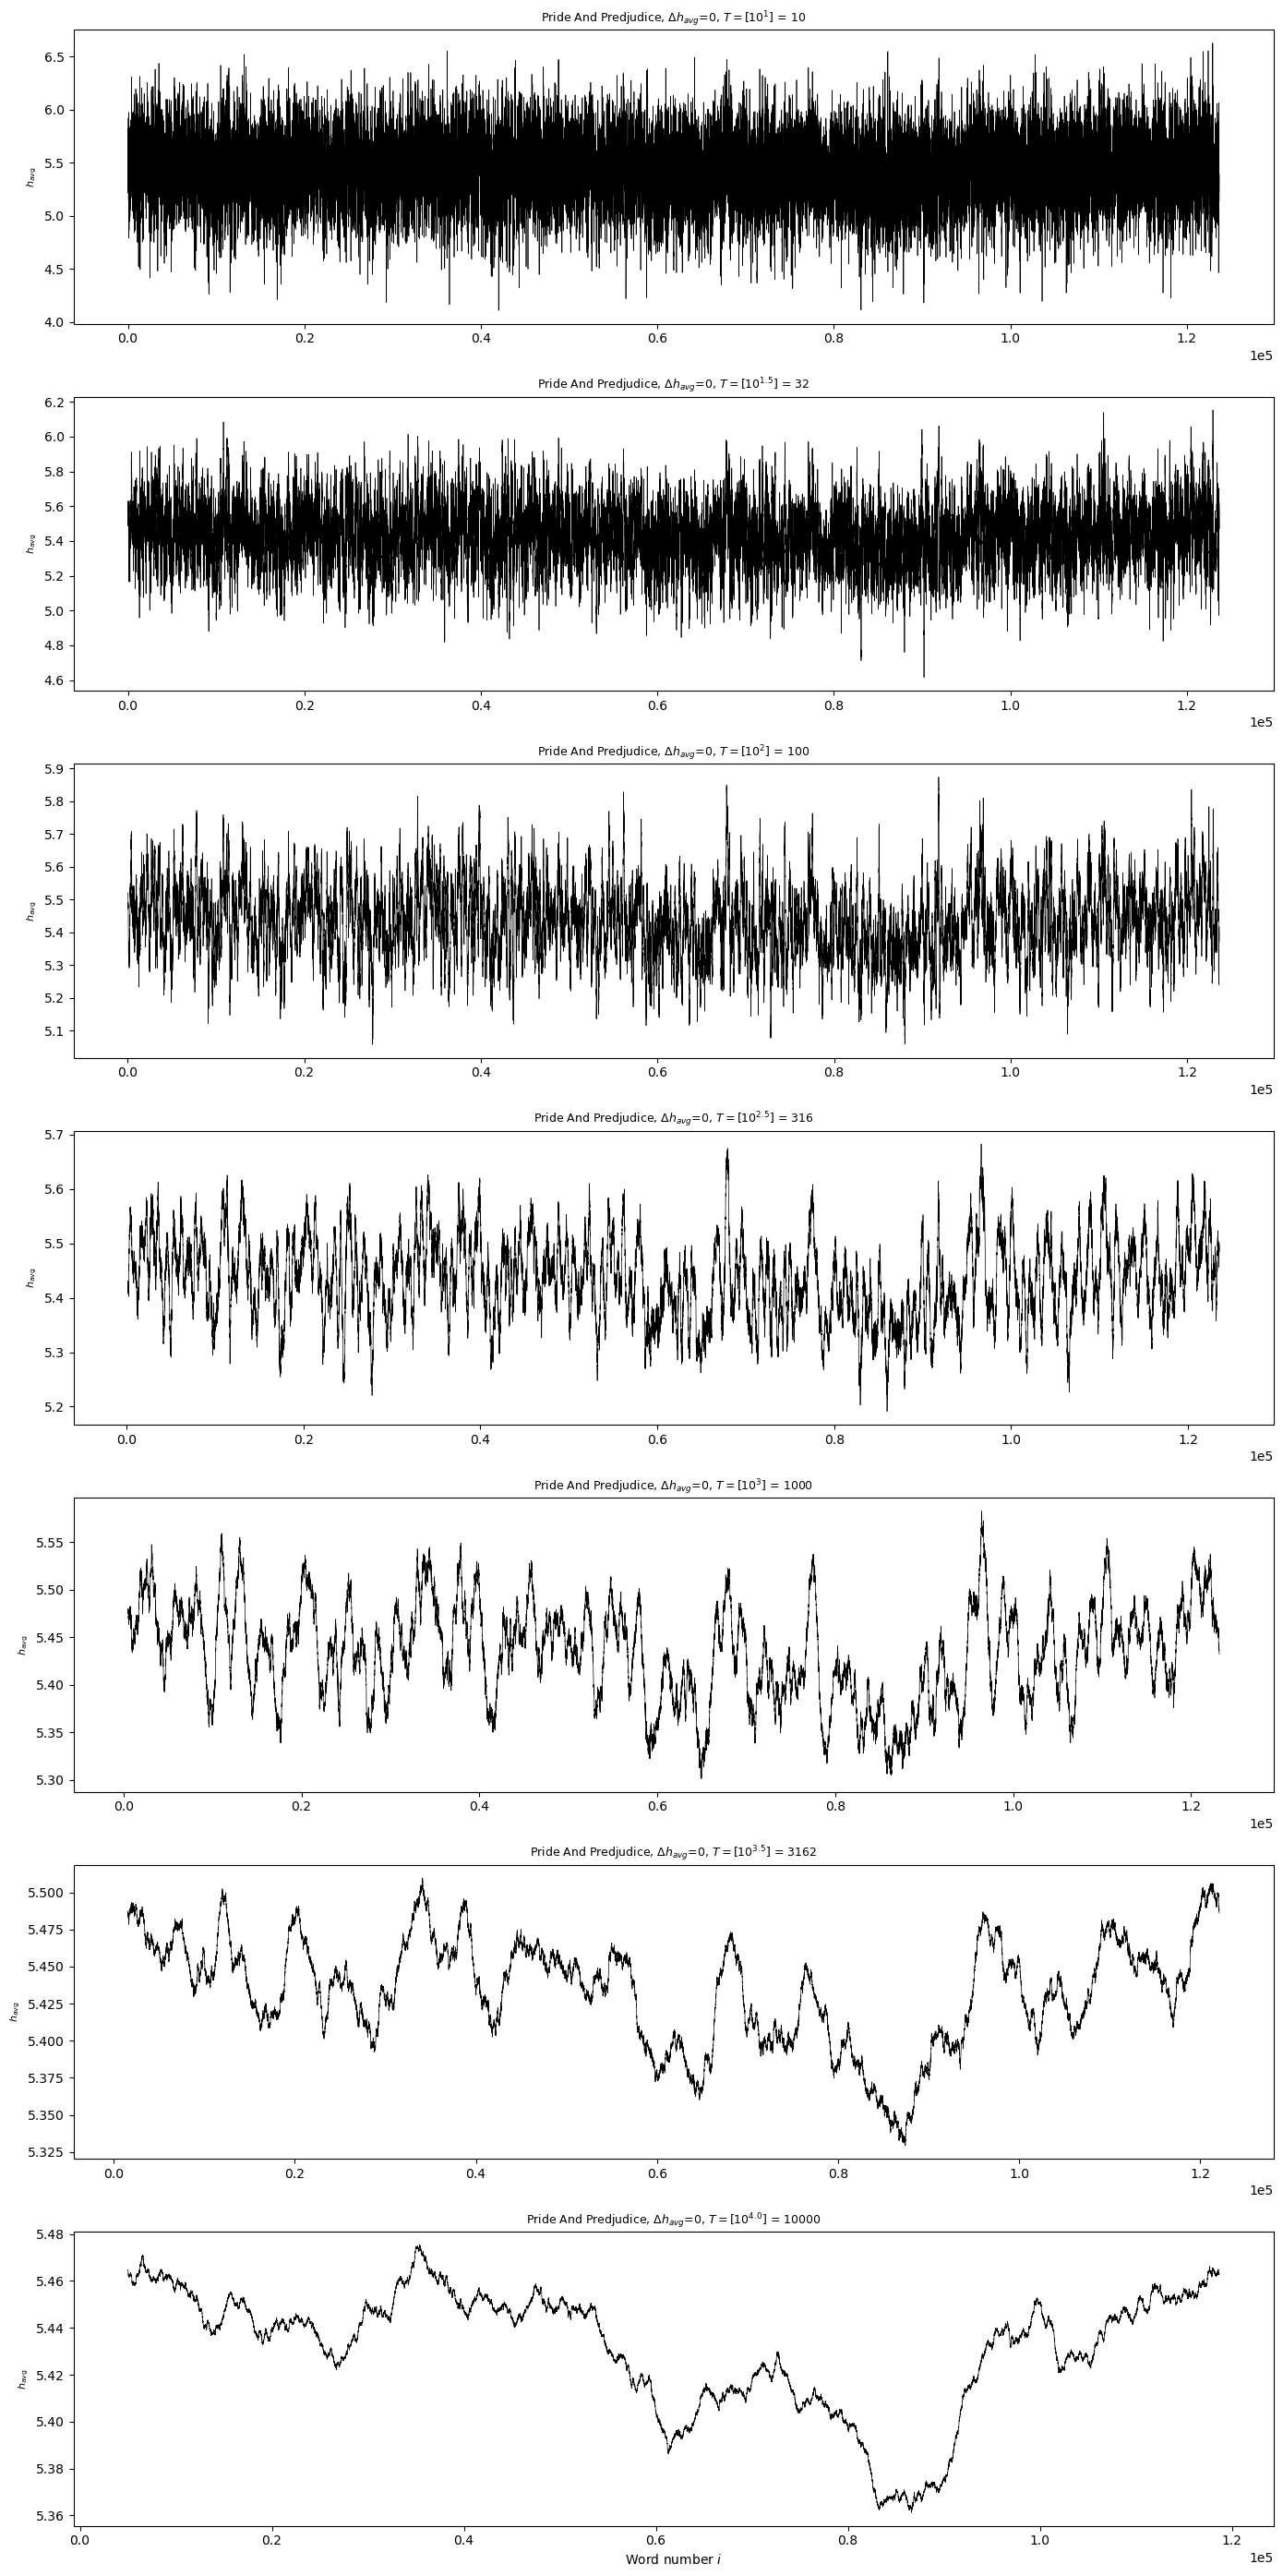

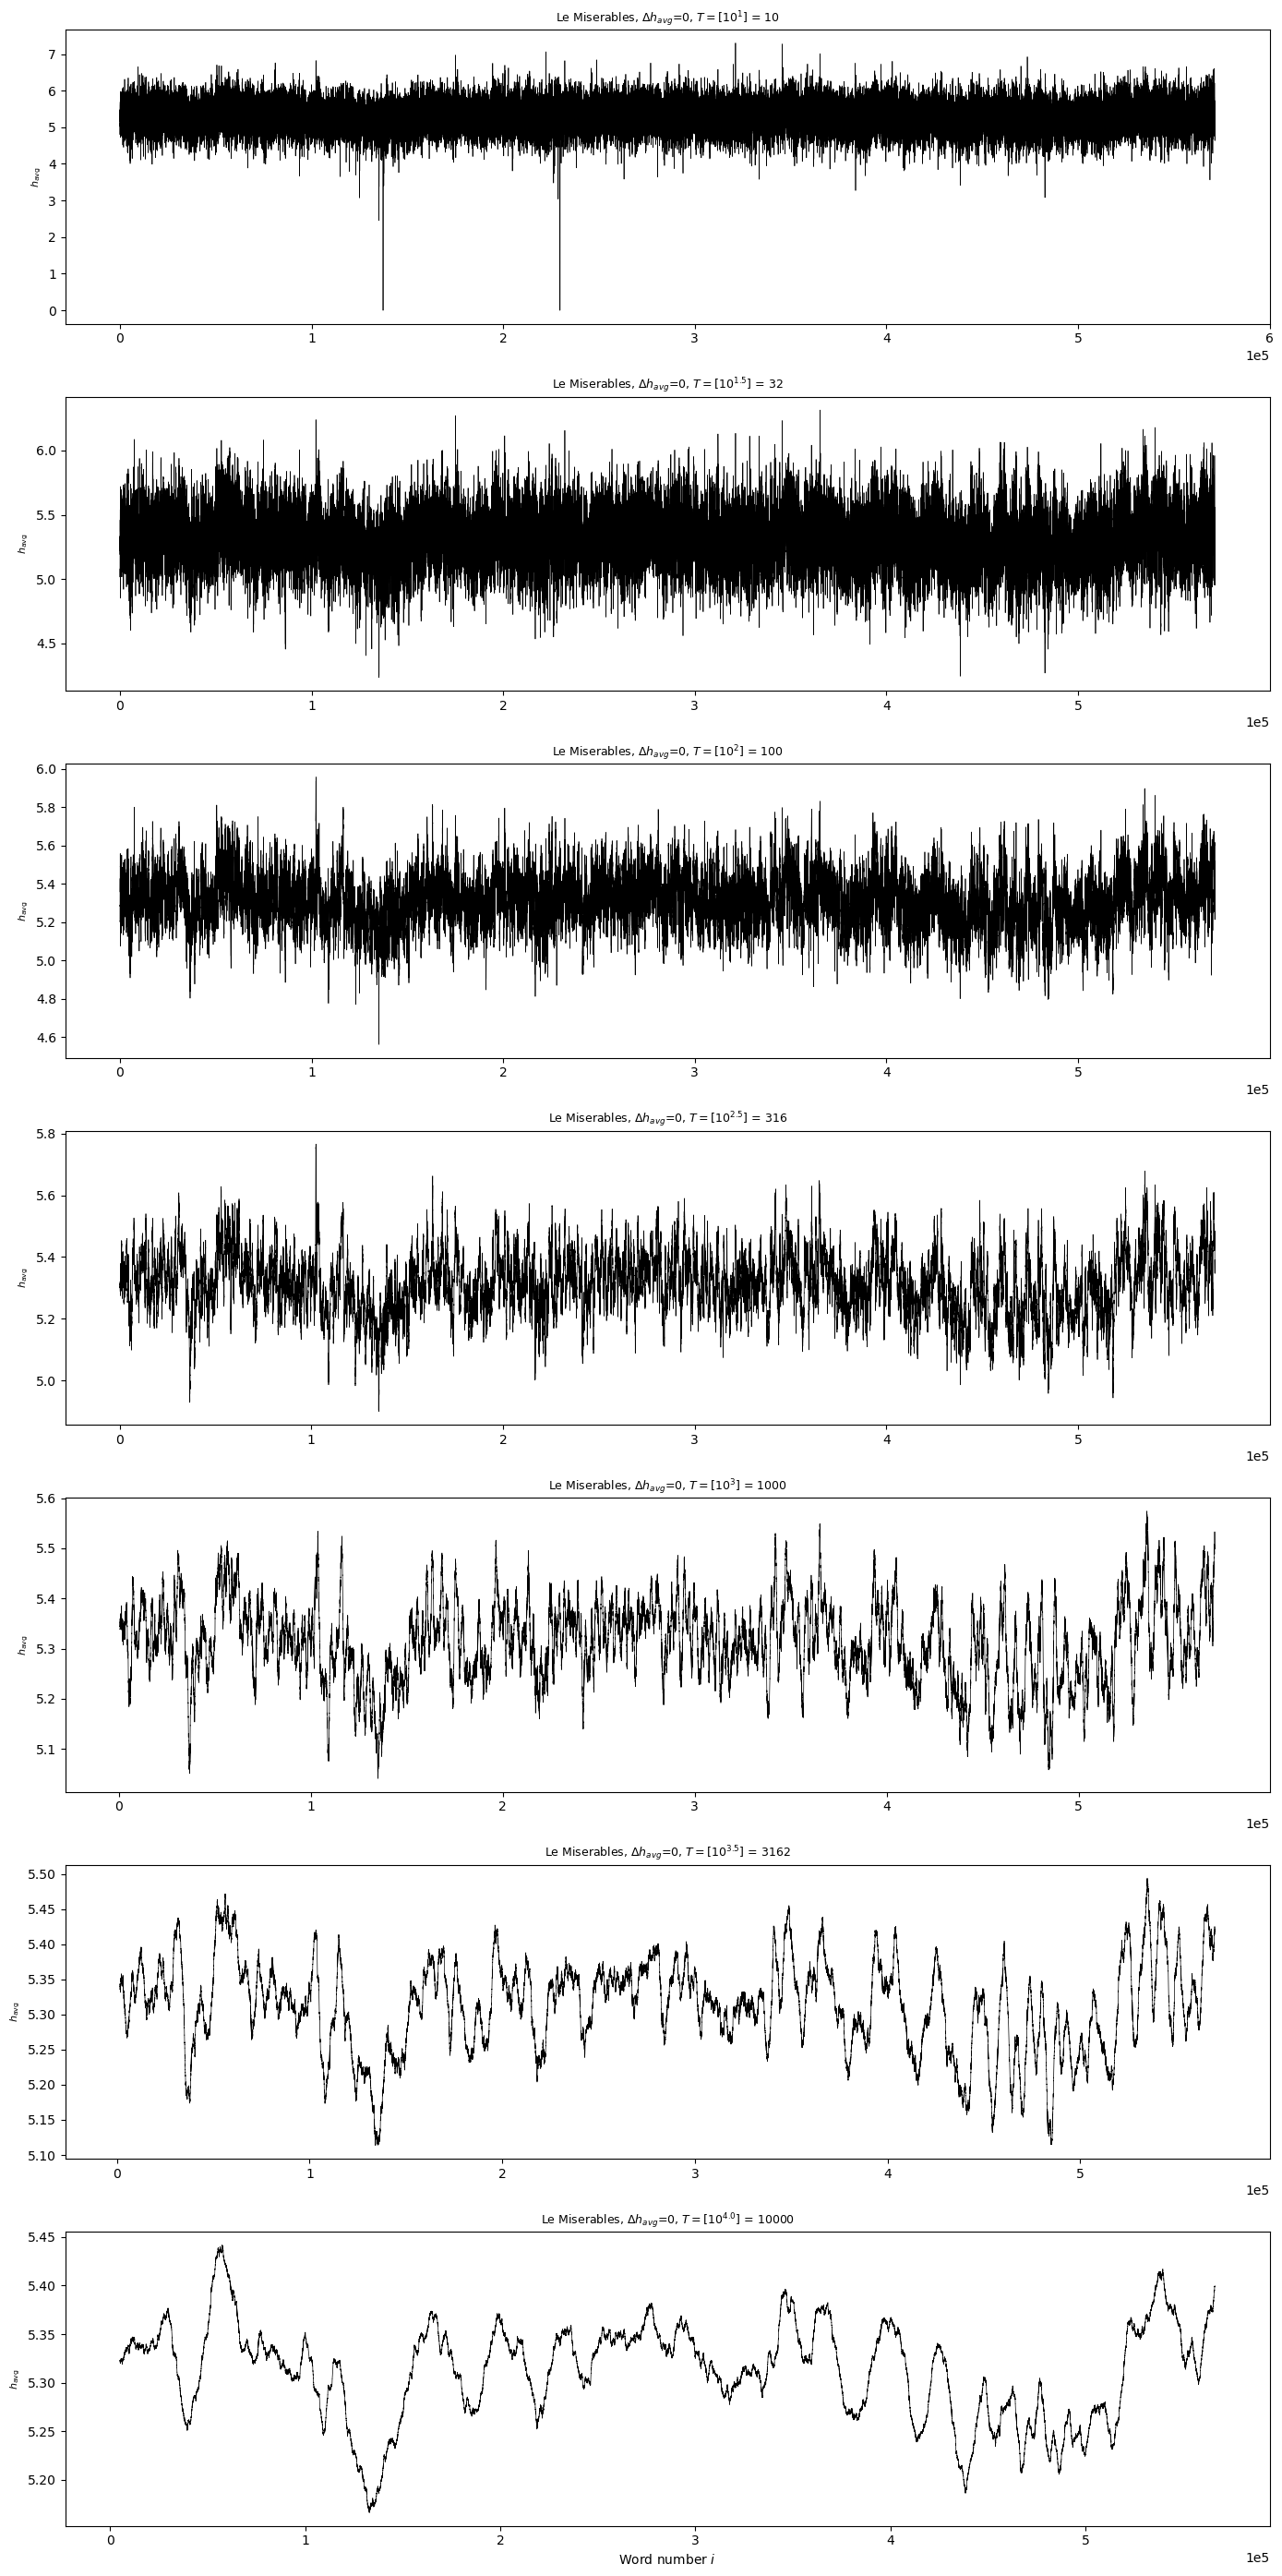

In [271]:
mu_values = [1, 1.5, 2, 2.5, 3, 3.5, 4.0]

# Full lexical lens: δh_avg = 0
score_lookup = get_labMT_score_lookup(window_size=0)

for story_name, story_word_list in story_words.items():
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 28), sharex=False)

    for ax, mu in zip(axes, mu_values):
        T = round(10**mu)  # update global T used by your functions

        scores, running_score, running_count = get_scores(story_word_list, score_lookup)
        scores, x_positions = get_time_series_scores(story_word_list, running_score, running_count, score_lookup, T)

        ax.plot(x_positions, scores, color='black', linewidth=0.5)
        ax.set_title(
            rf'{story_name.replace("_", " ").title()}, $\Delta h_{{avg}}$=0, $T = [10^{{{mu}}}]$ = {T}',
            fontsize=9
        )
        ax.set_ylabel(r'$h_{\mathrm{avg}}$', fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    axes[-1].set_xlabel('Word number $i$')
    plt.tight_layout()
    plt.savefig(f"assignment_2_plots/{story_name}_stacked_full_lexical_lens.png", dpi=150)
    plt.show()

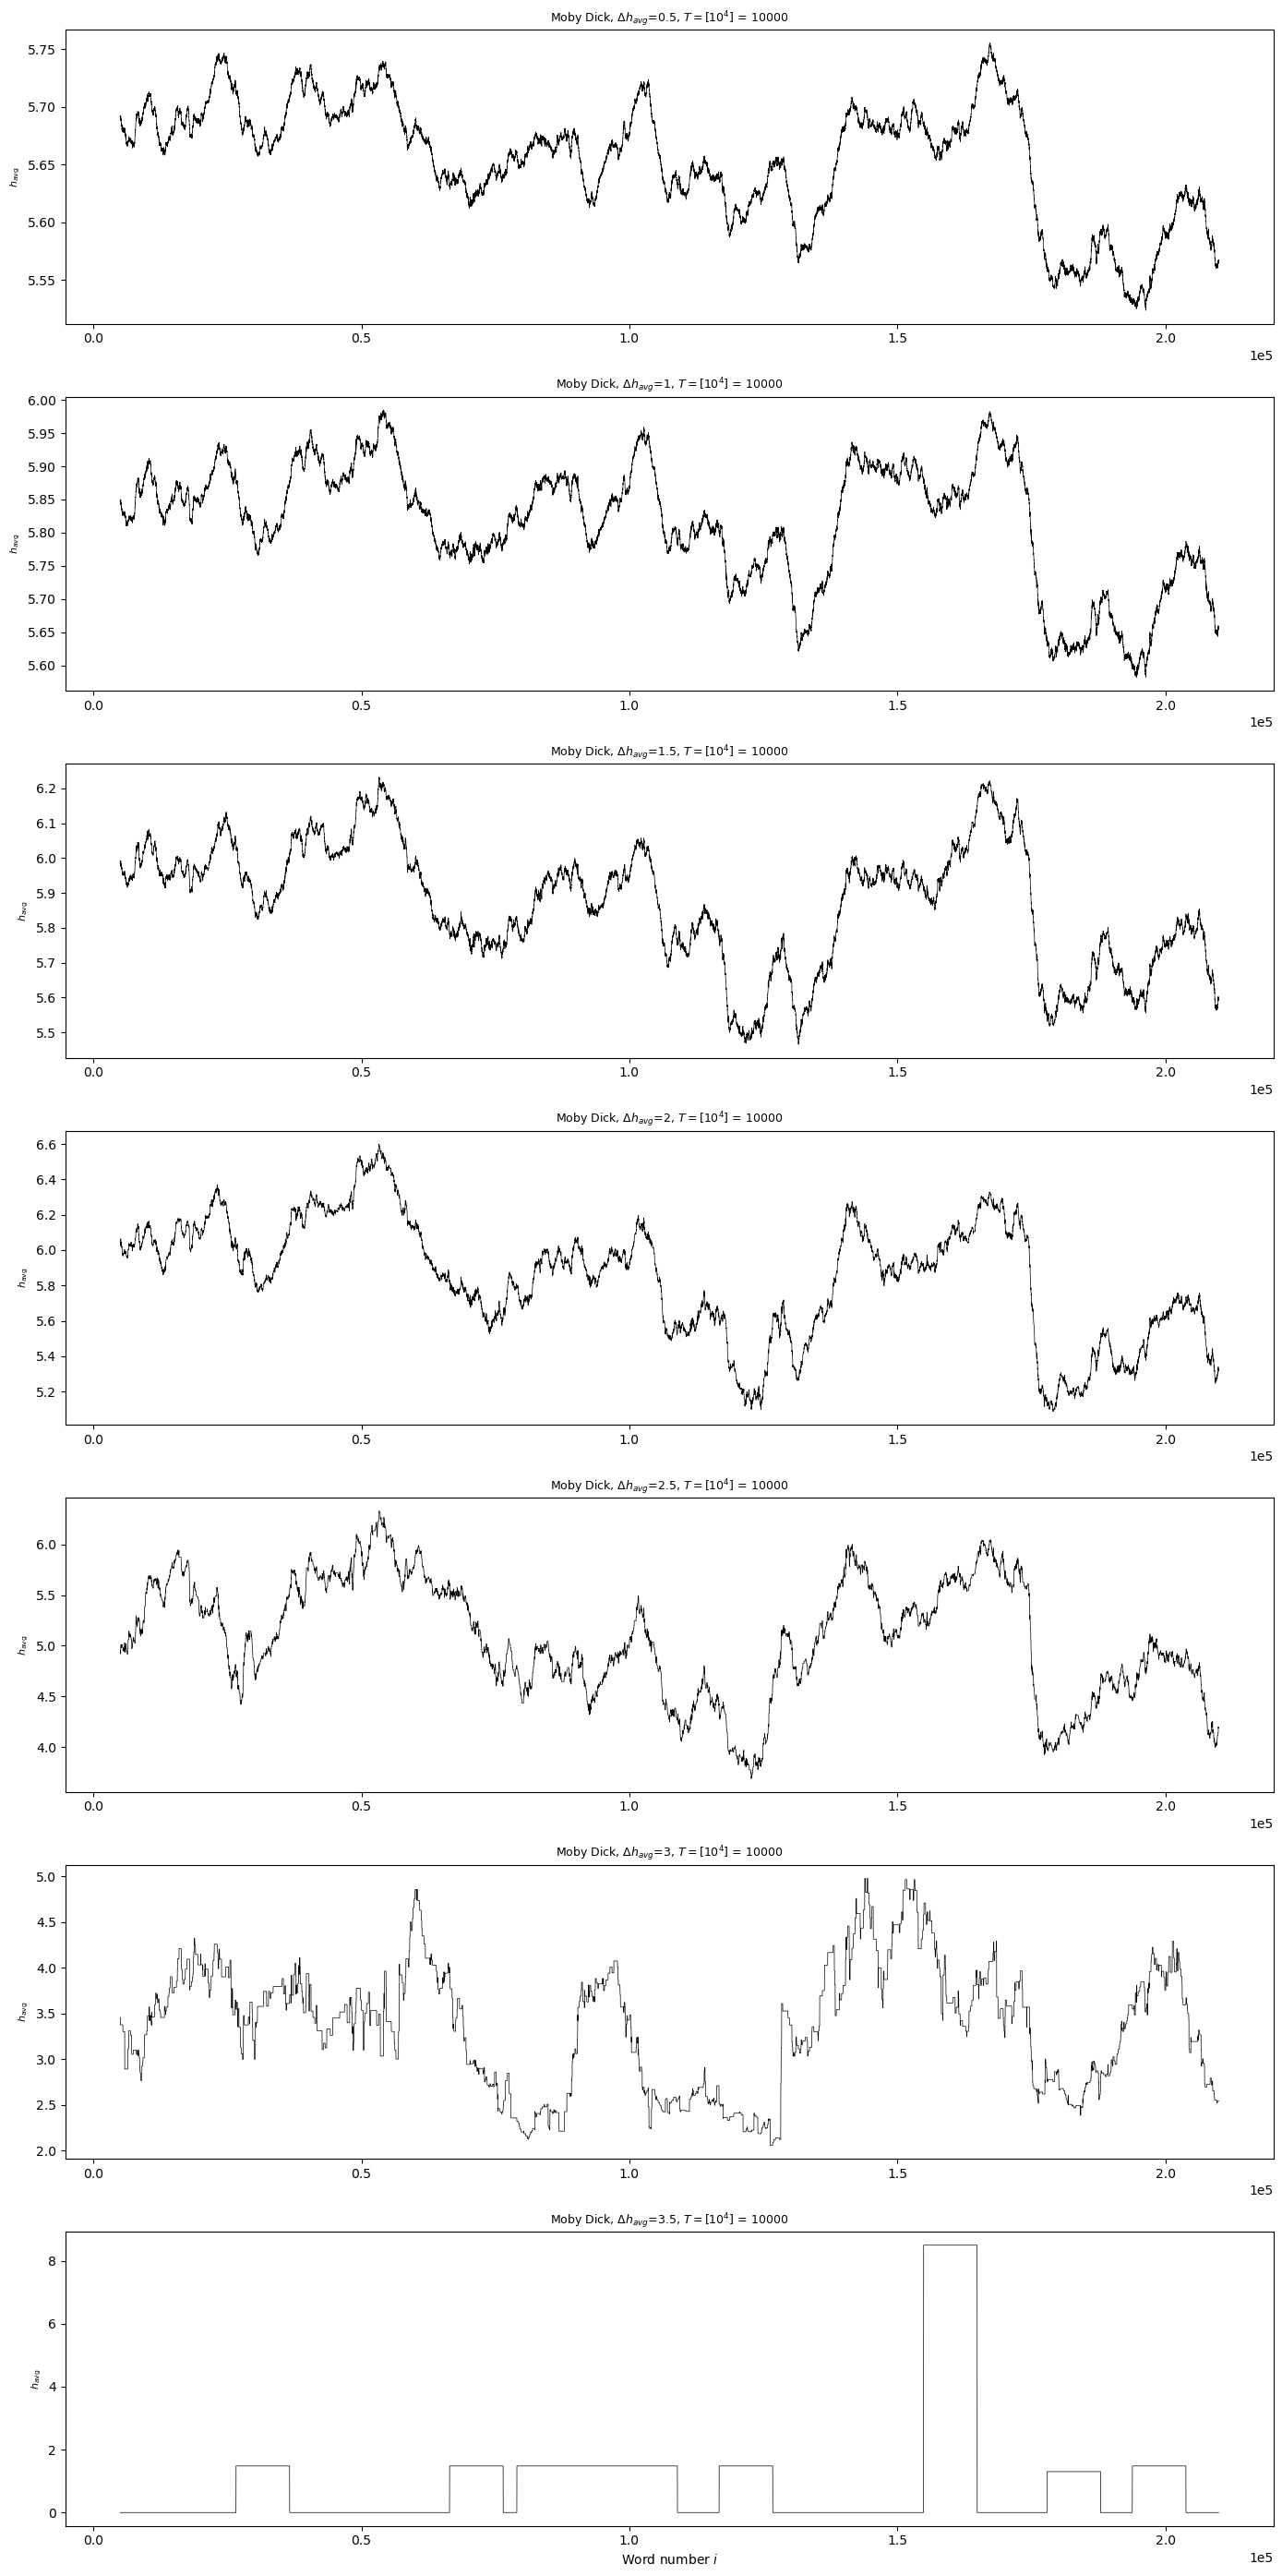

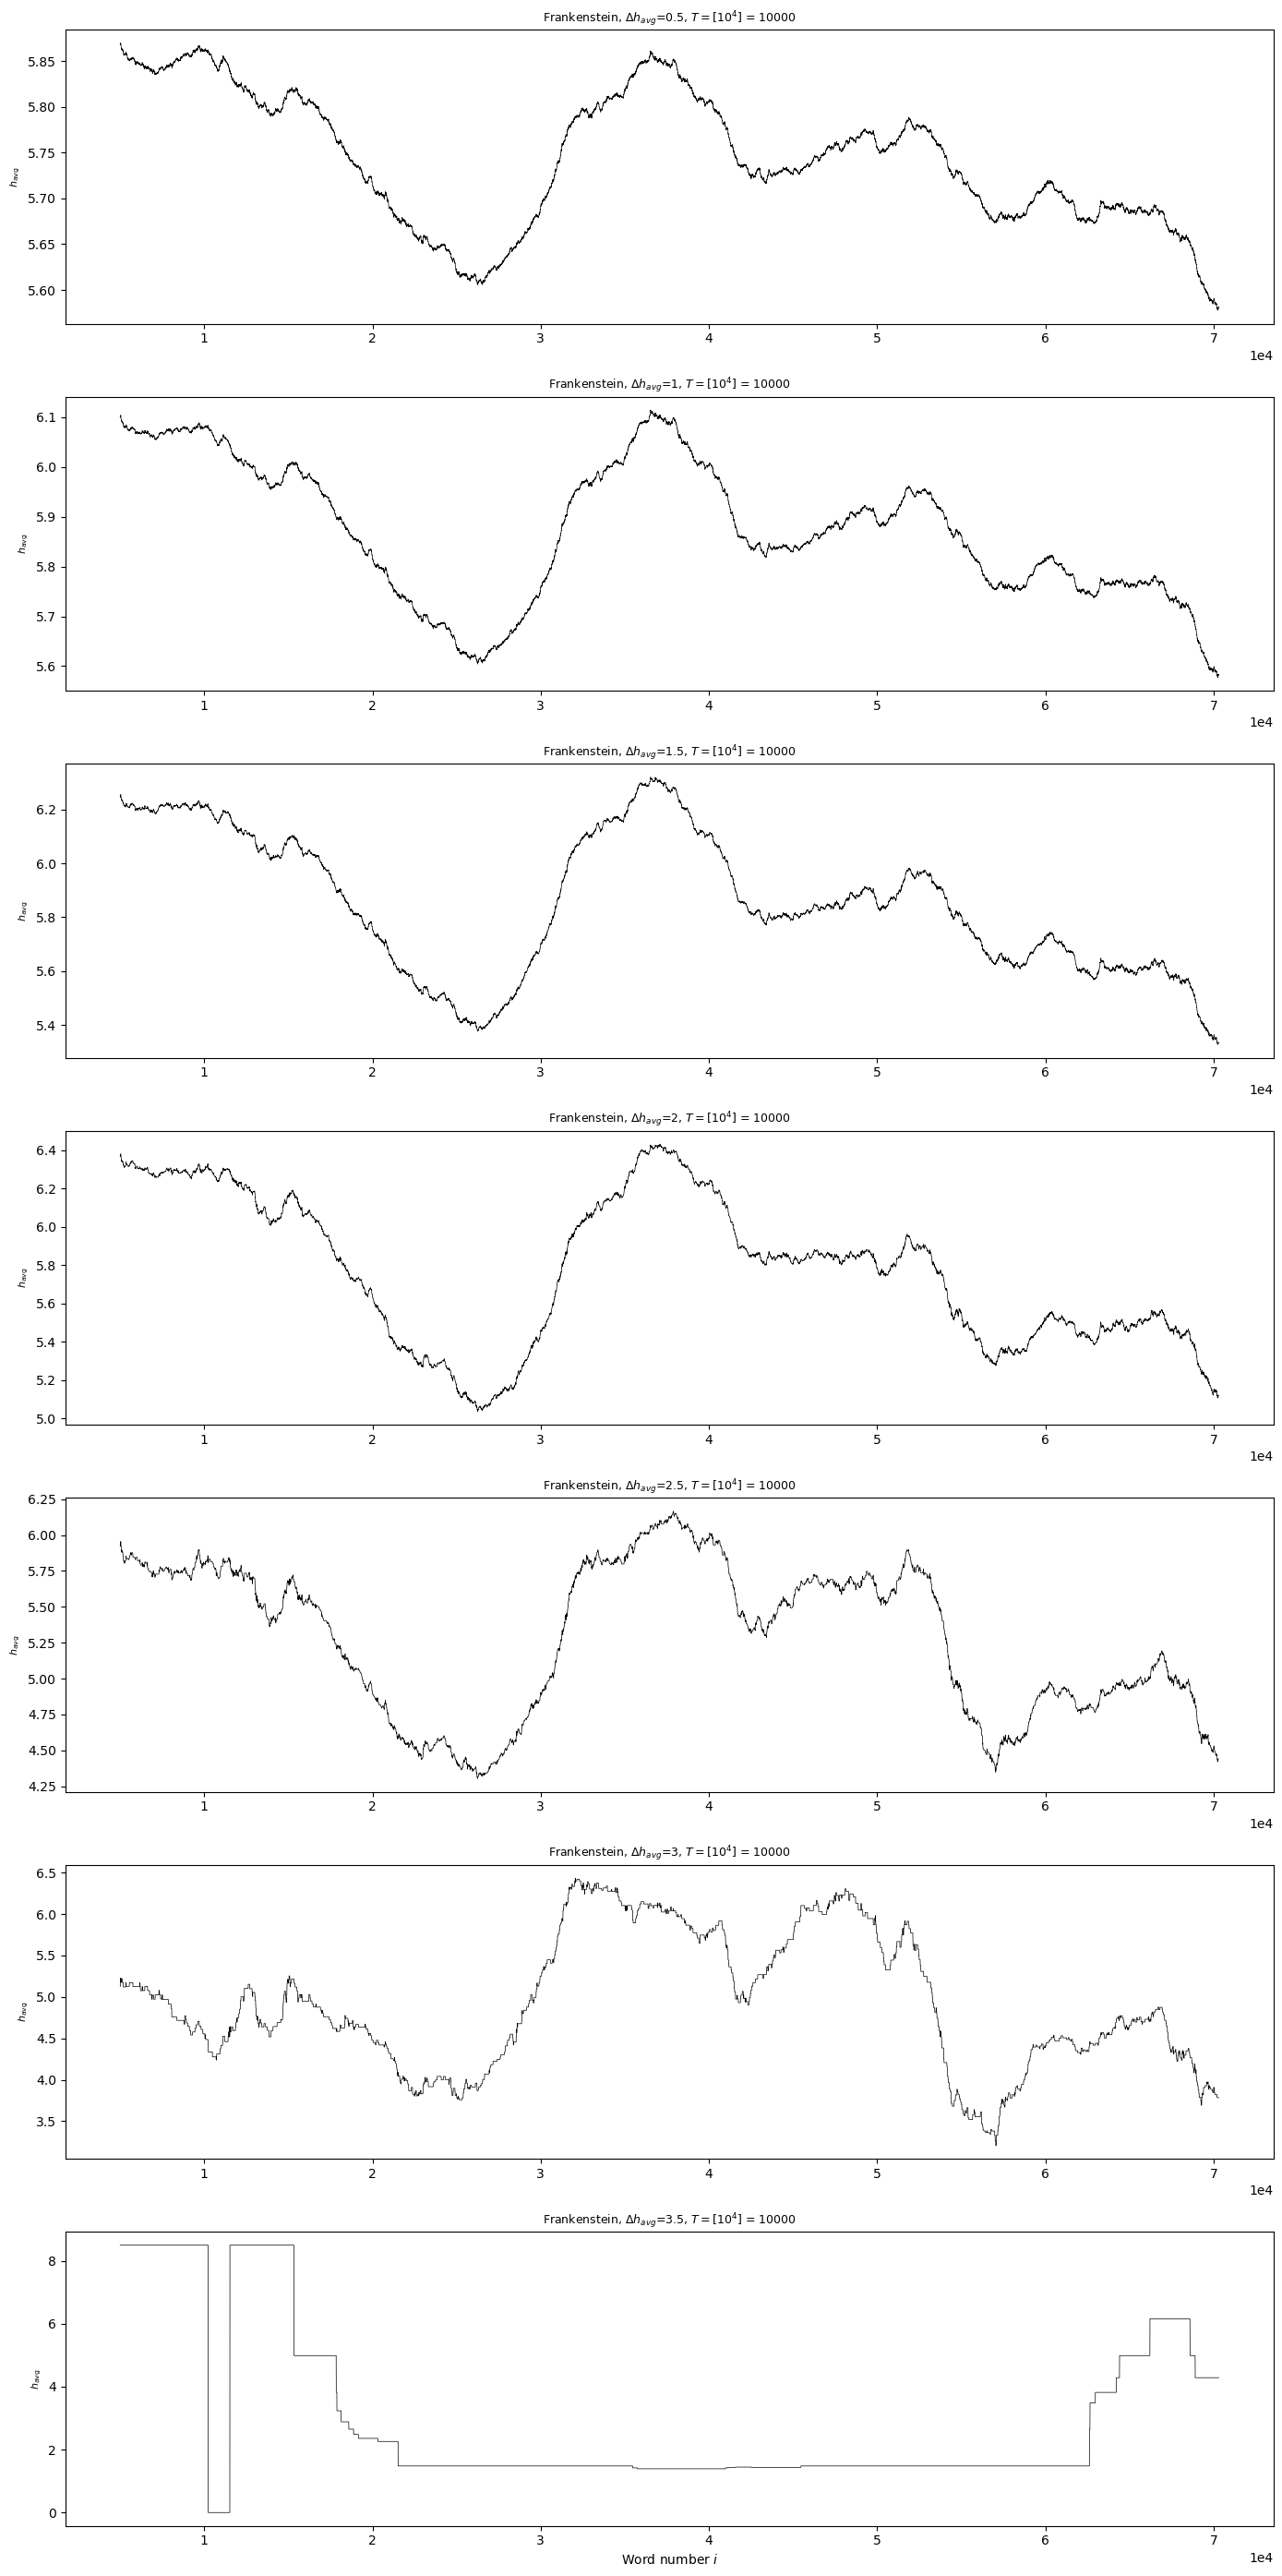

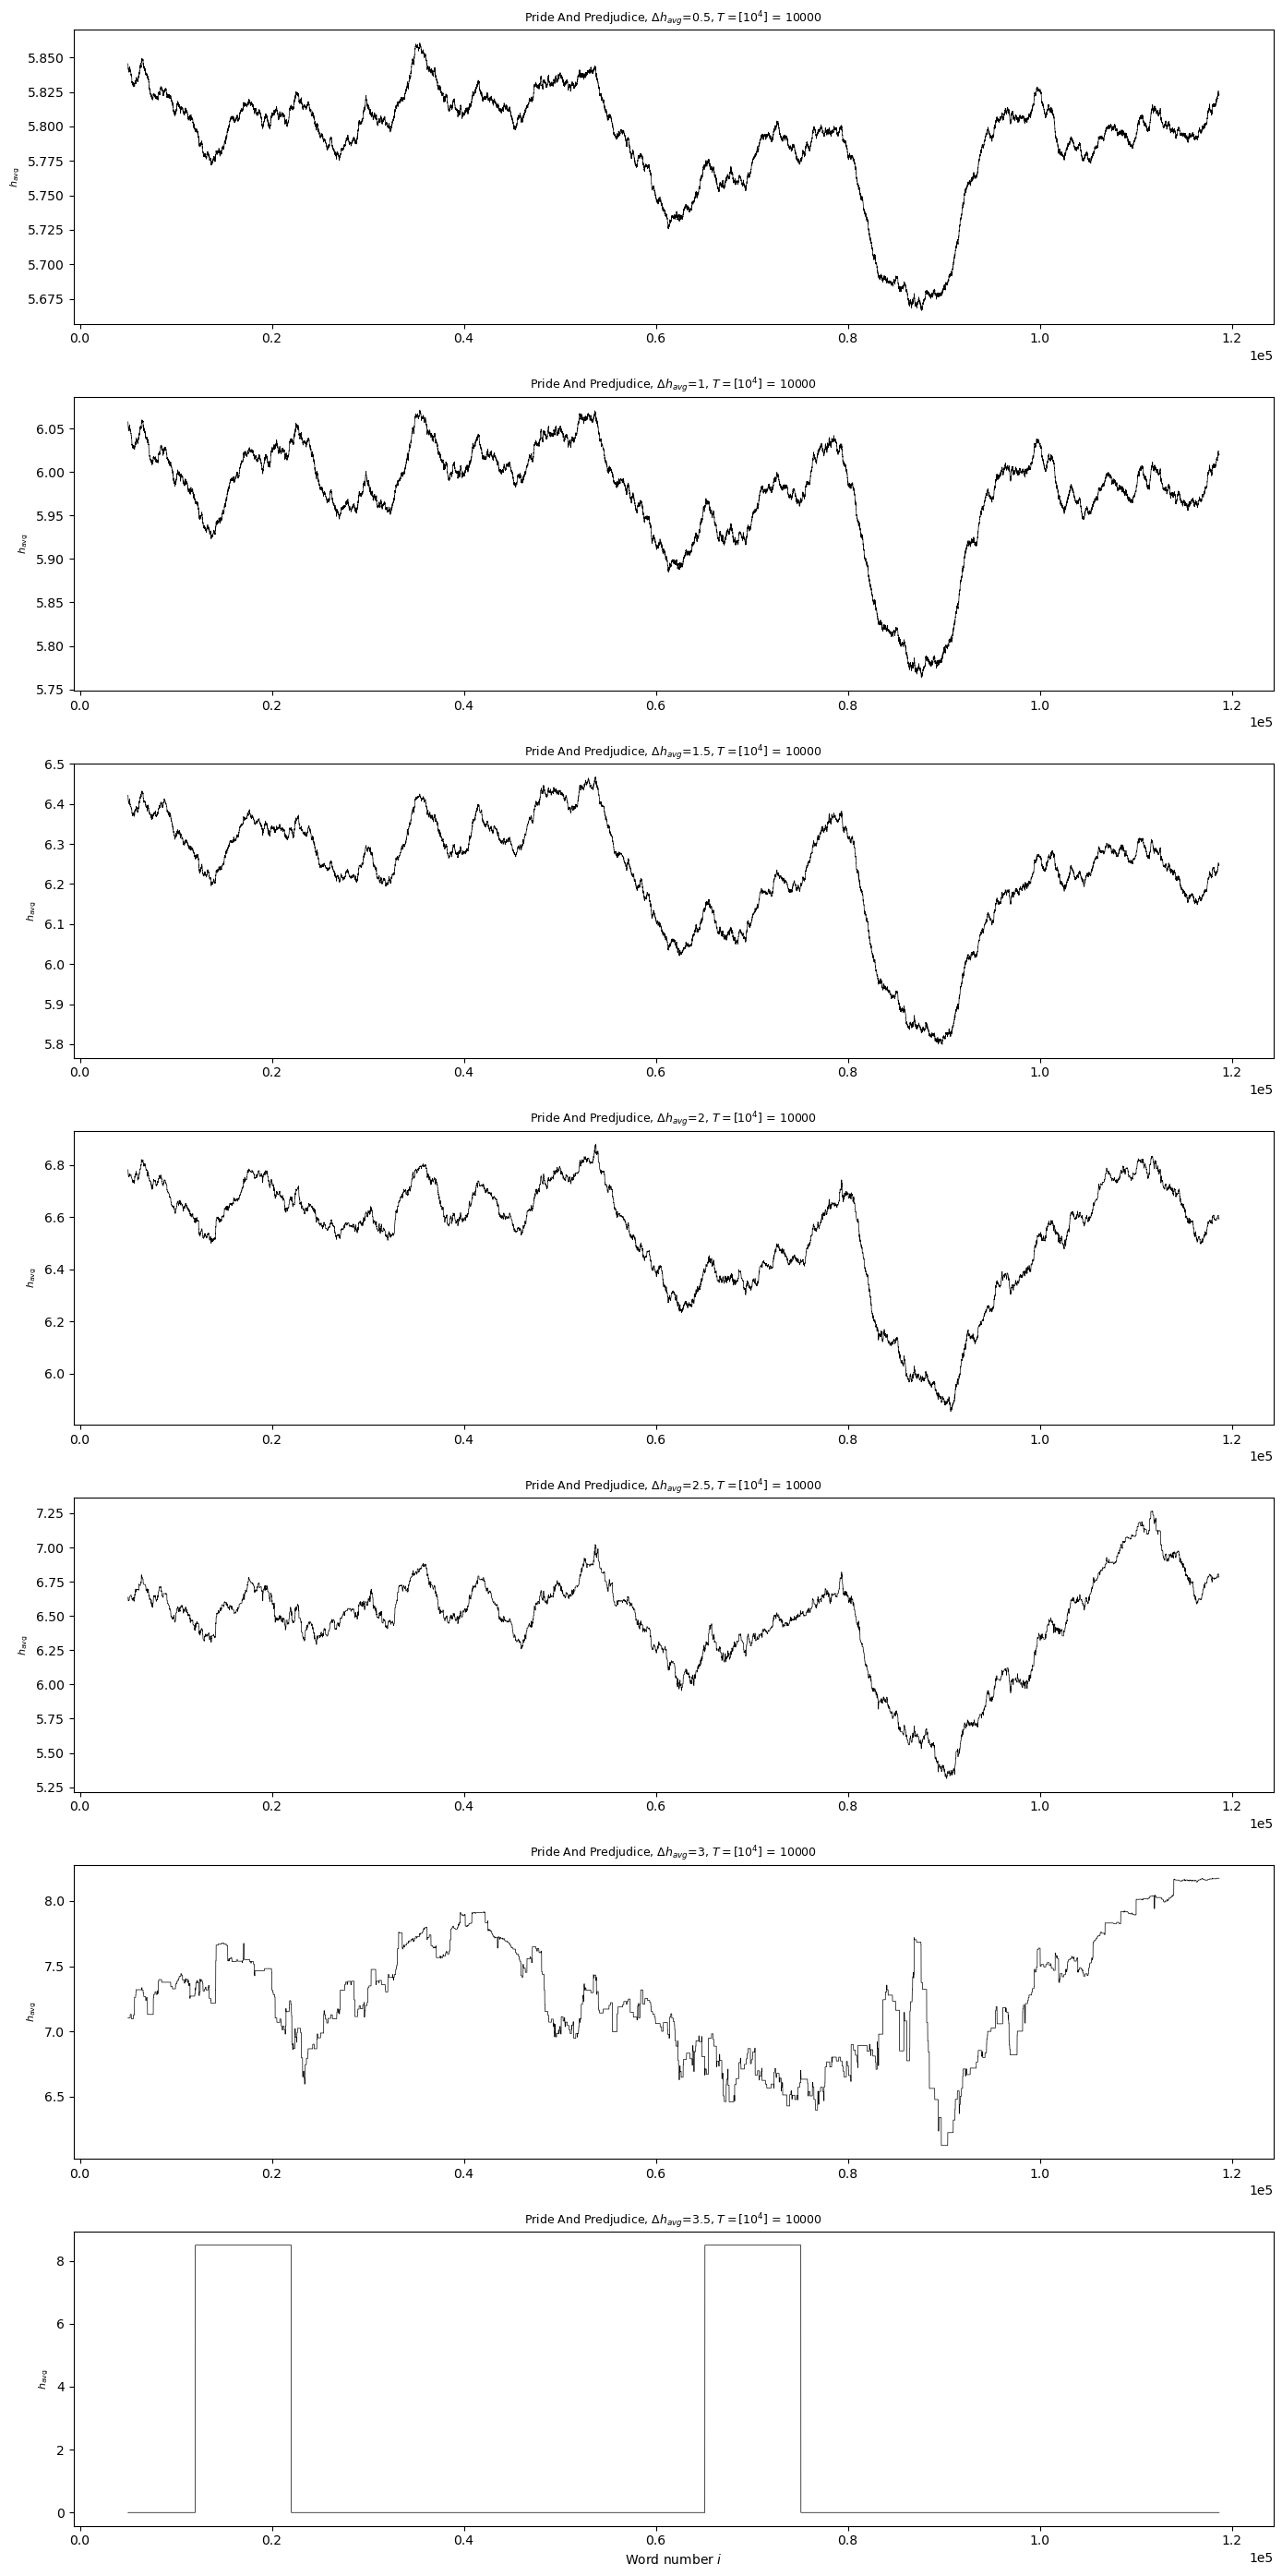

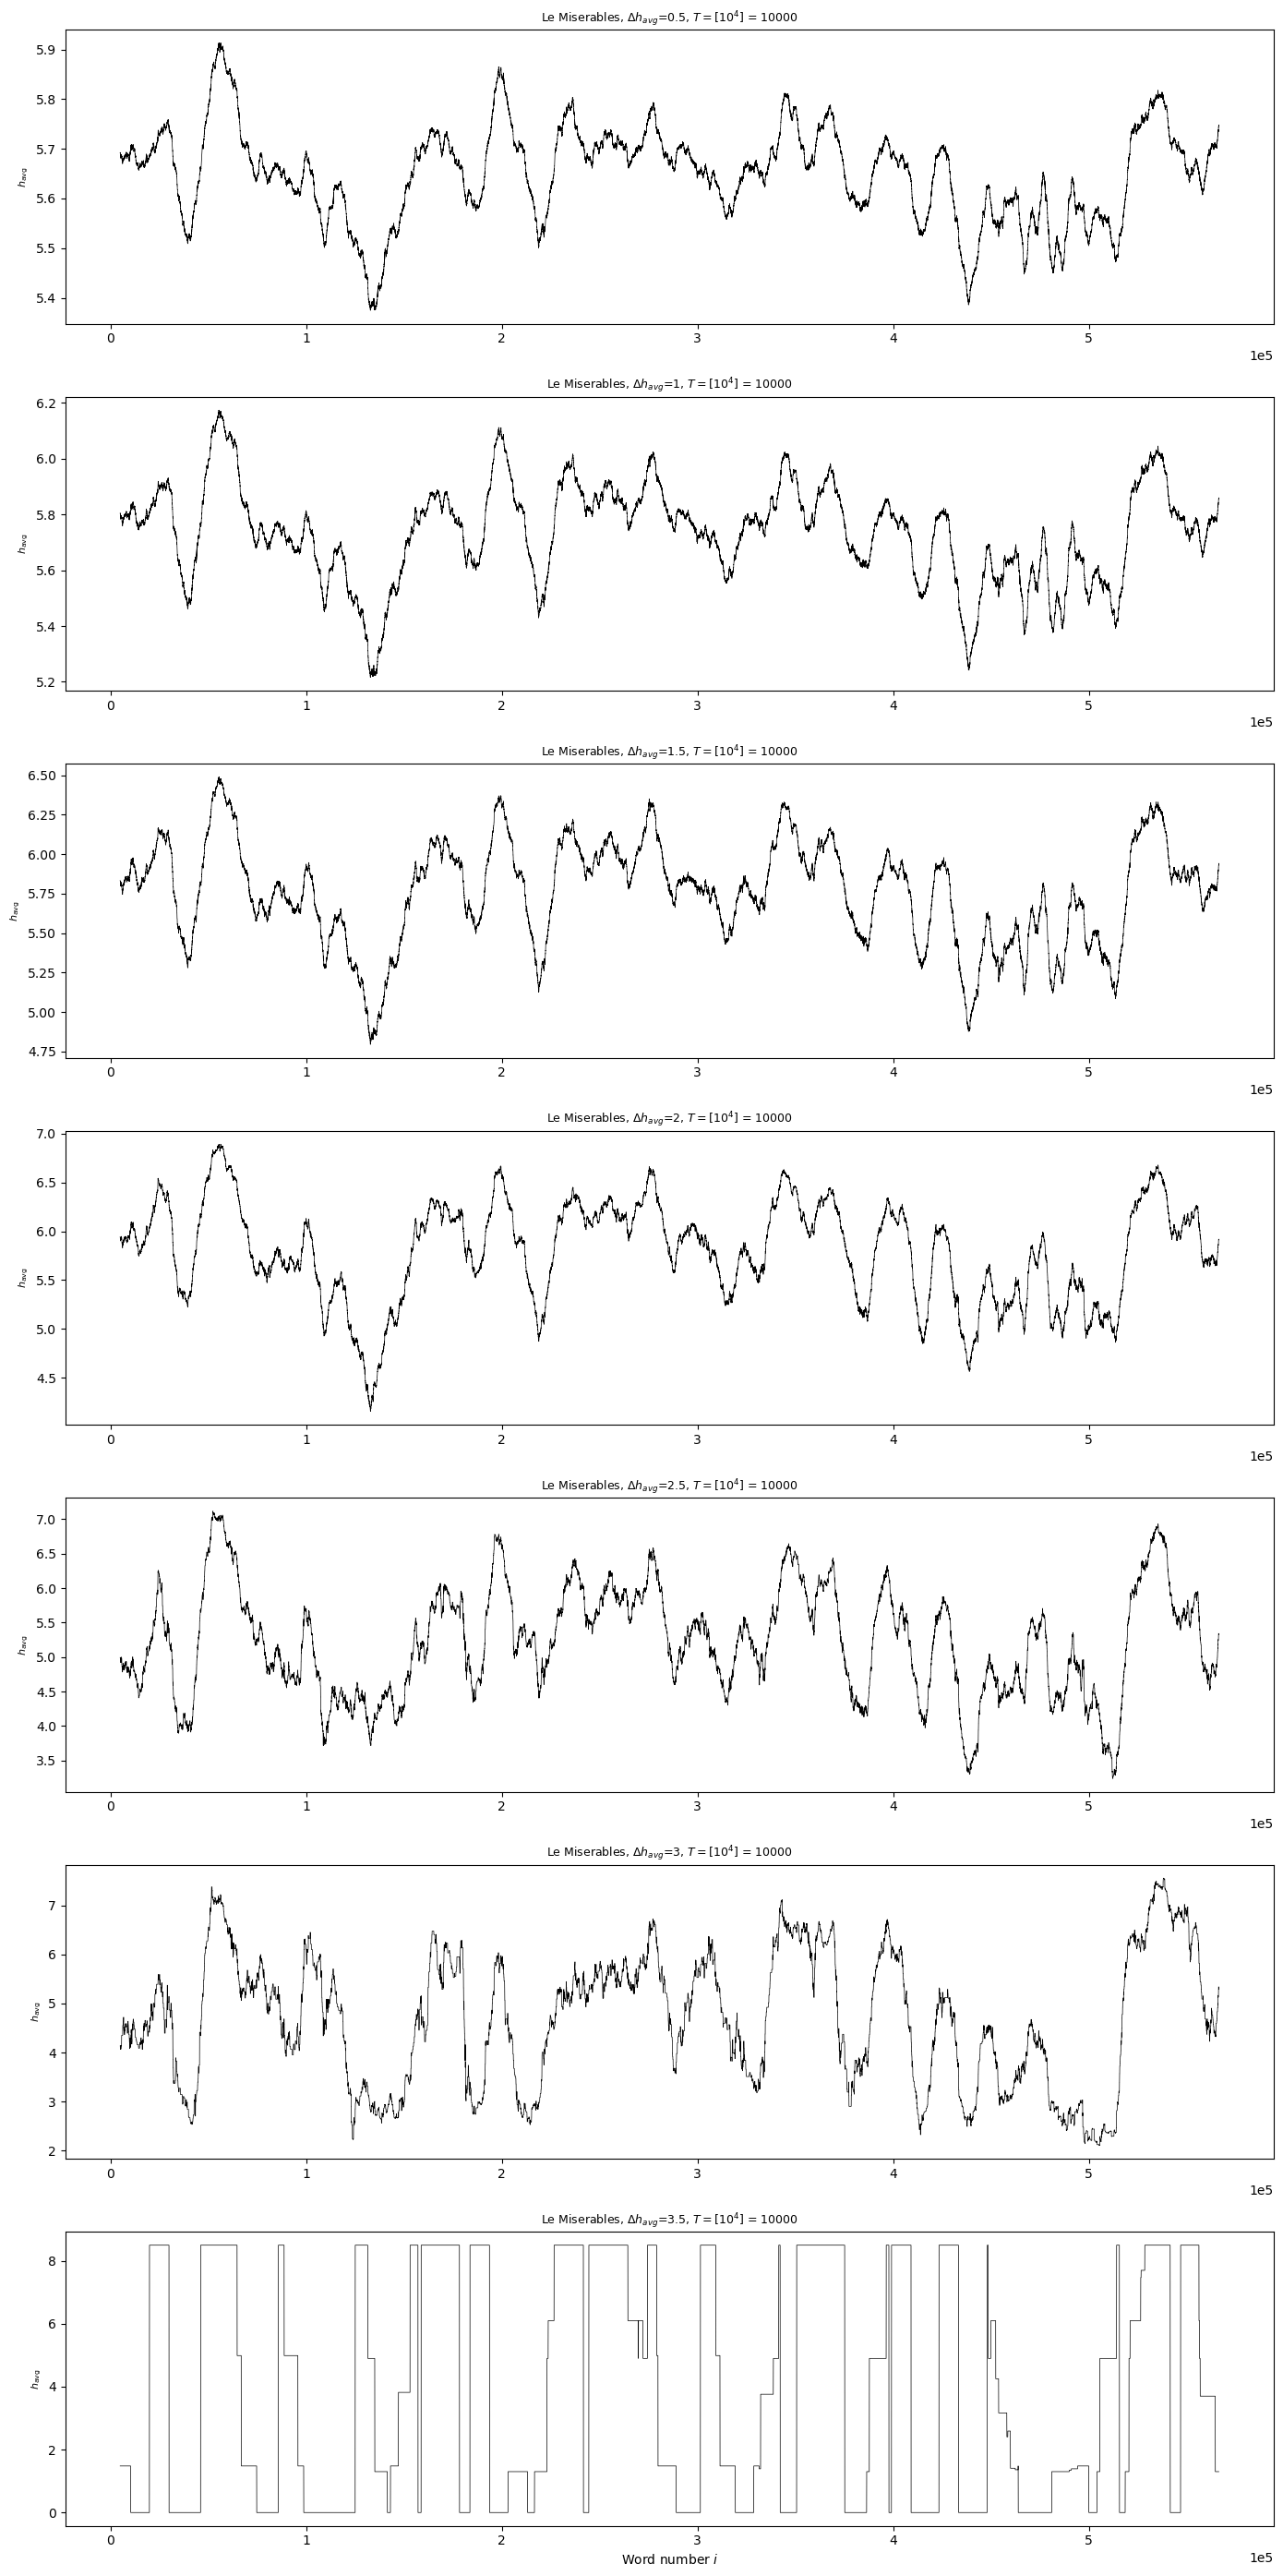

In [272]:
h_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

for story_name, story_word_list in story_words.items():
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 28), sharex=False)

    for ax, h in zip(axes, h_values):
        score_lookup = get_labMT_score_lookup(window_size=h)

        T = round(10**4)  # update global T used by your functions

        scores, running_score, running_count = get_scores(story_word_list, score_lookup)
        scores, x_positions = get_time_series_scores(story_word_list, running_score, running_count, score_lookup, T)

        ax.plot(x_positions, scores, color='black', linewidth=0.5)
        ax.set_title(
            rf'{story_name.replace("_", " ").title()}, $\Delta h_{{avg}}$={h}, $T = [10^{{{4}}}]$ = {T}',
            fontsize=9
        )
        ax.set_ylabel(r'$h_{\mathrm{avg}}$', fontsize=8)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    axes[-1].set_xlabel('Word number $i$')
    plt.tight_layout()
    plt.savefig(f"assignment_2_plots/{story_name}_moving_lens.png", dpi=150)
    plt.show()

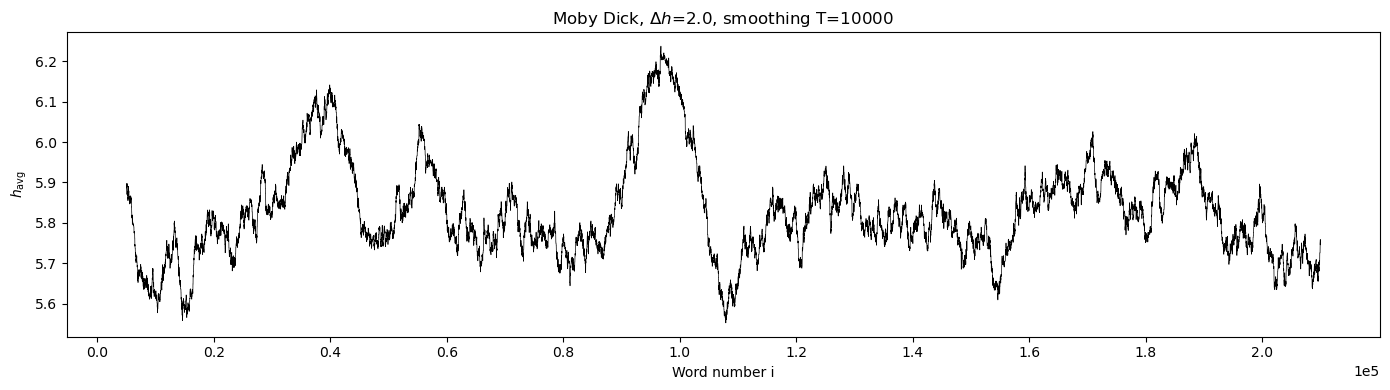

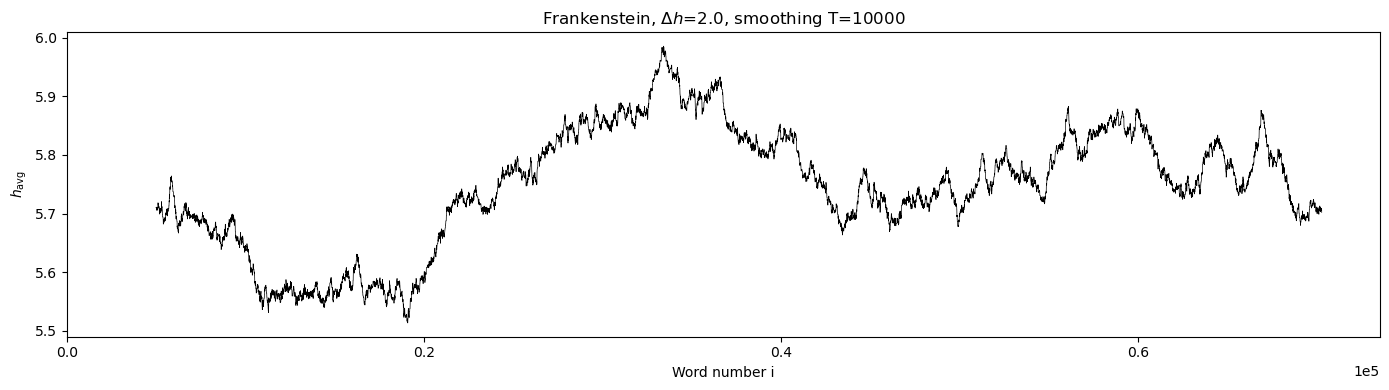

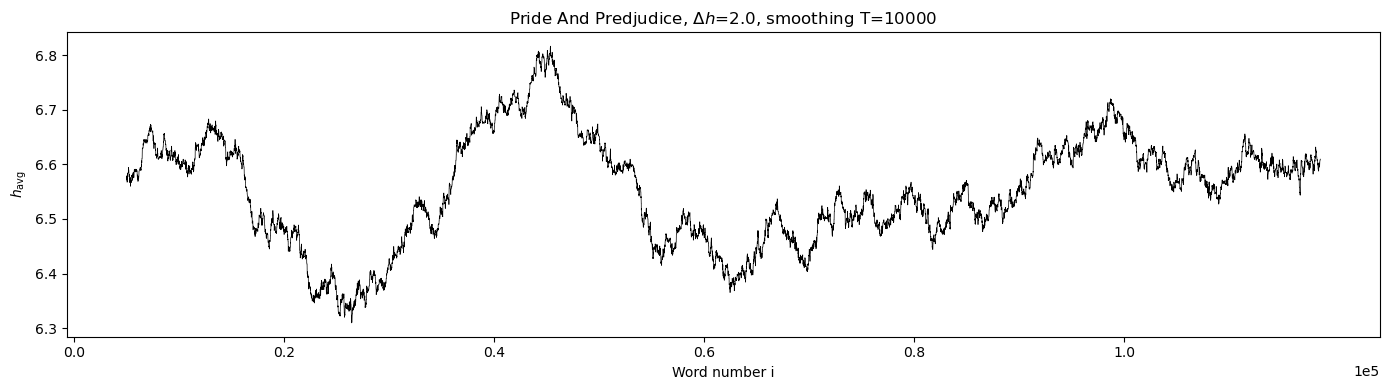

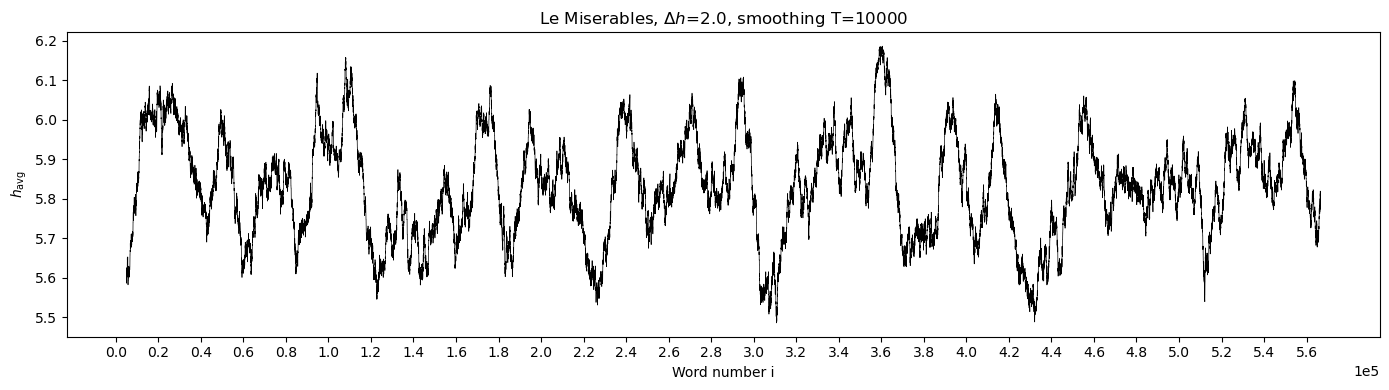

In [277]:
story_words = {
    "moby_dick": shuffled_md_words,
    "frankenstein": shuffled_frankenstein_words,
    "pride_and_predjudice": shuffled_pap_words,
    "le_miserables": shuffled_lm_words,
}

for story_name, story_word_list in story_words.items():
    fig, ax = plt.subplots(figsize=(14, 4))
    T = round(10**4)  # update global T used by your functions
    scores, running_score, running_count = get_scores(story_word_list, get_labMT_score_lookup(window_size=2))
    scores, x_positions = get_time_series_scores(story_word_list, running_score, running_count, get_labMT_score_lookup(window_size=2), T=T)

    ax.plot(x_positions, scores, color='black', linewidth=0.5)

    # Title and labels
    ax.set_title(rf'{story_name.replace("_", " ").title()}, $\Delta h$=2.0, smoothing T={T}')
    ax.set_ylabel(r'$h_{\mathrm{avg}}$')
    ax.set_xlabel('Word number i')
    ax.set_xticks(np.arange(0, max(x_positions), 20000))

    # Format x-axis as ×10^5
    ax.ticklabel_format(style='sci', axis='x', scilimits=(5,5))

    plt.tight_layout()
    plt.savefig(f"assignment_2_plots/{story_name}_shuffled.png", dpi=150)
    plt.show()